### Preprocessing
- Load your dataset
- Handle missing values
- Convert units if needed
- Generate basic visualizations

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load dataset
file_path = "Puducherry.csv"  # Change to your actual file path
df = pd.read_csv(file_path, parse_dates=["date"])

In [4]:
# Display initial dataset info
print("Dataset Info:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123936 entries, 0 to 123935
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   Unnamed: 0            123936 non-null  int64              
 1   date                  123936 non-null  datetime64[ns, UTC]
 2   temperature_2m        123936 non-null  float64            
 3   relative_humidity_2m  123936 non-null  float64            
 4   dew_point_2m          123936 non-null  float64            
 5   apparent_temperature  123936 non-null  float64            
 6   precipitation         123936 non-null  float64            
 7   rain                  123936 non-null  float64            
 8   snowfall              123936 non-null  float64            
 9   snow_depth            123936 non-null  float64            
 10  pressure_msl          123936 non-null  float64            
 11  surface_pressure      123936 non-null 

In [5]:
# Handle missing values (linear interpolation)
df.interpolate(method="linear", inplace=True)

In [6]:
# Drop rows with excessive missing values (optional)
df.dropna(thresh=len(df.columns) - 2, inplace=True)

In [7]:
# Convert temperature from Kelvin to Celsius if needed (assuming dataset uses Kelvin)
if df["temperature_2m"].max() > 100:
    df["temperature_2m"] = df["temperature_2m"] - 273.15
    df["dew_point_2m"] = df["dew_point_2m"] - 273.15
    df["apparent_temperature"] = df["apparent_temperature"] - 273.15

In [8]:
# Save the cleaned dataset
df.to_csv("cleaned_weather_data.csv", index=False)
print("Cleaned dataset saved!")

Cleaned dataset saved!


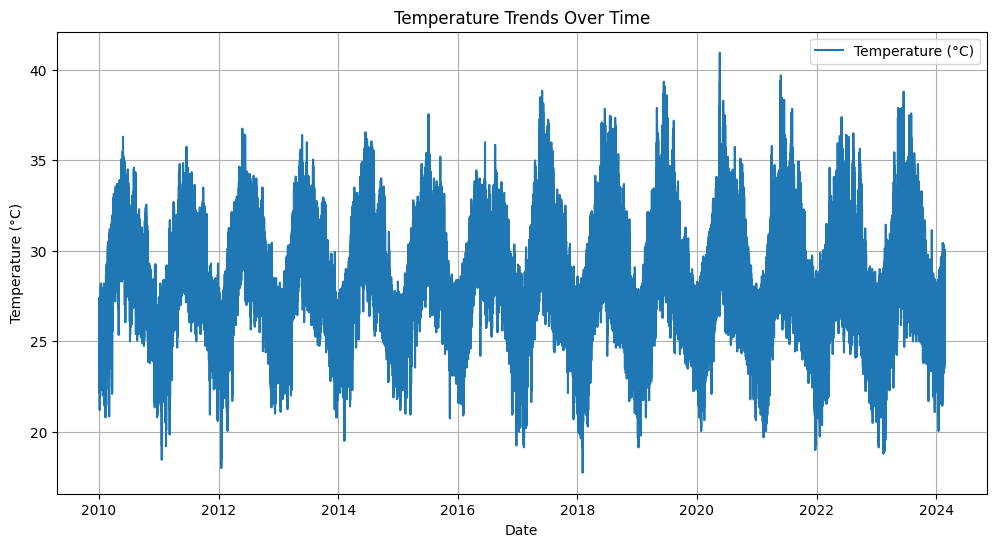

In [9]:
# Visualization - Temperature Trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="date", y="temperature_2m", label="Temperature (°C)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Trends Over Time")
plt.legend()
plt.grid()
plt.show()

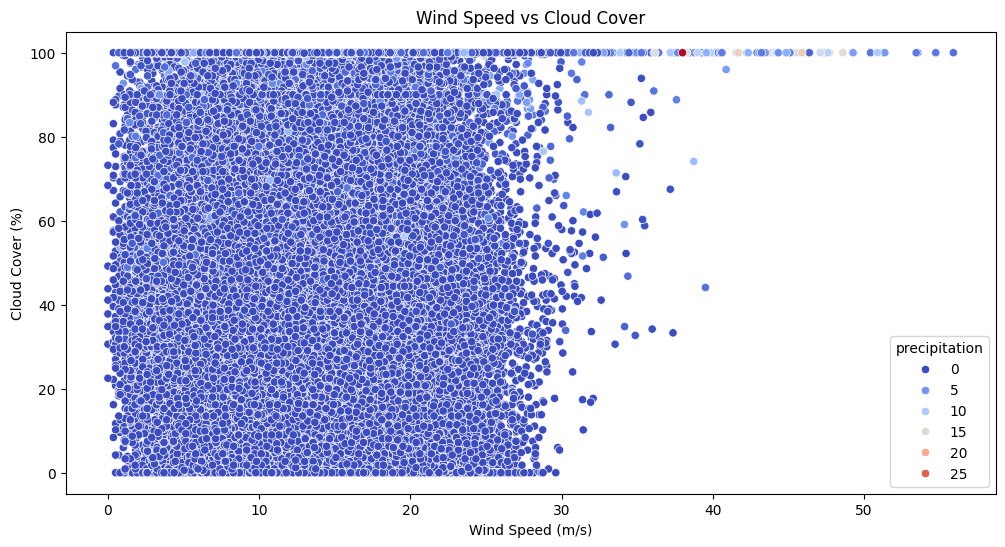

In [10]:
# Visualization - Wind Speed vs. Cloud Cover
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x="wind_speed_10m", y="cloud_cover", hue="precipitation", palette="coolwarm")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Cloud Cover (%)")
plt.title("Wind Speed vs Cloud Cover")
plt.show()

### EnKF for Weather Prediction
- Load the cleaned weather dataset
- Apply the Ensemble Kalman Filter for data assimilation
- Predict the next time steps using EnKF
- Visualize the results (forecast vs. actual data)

In [11]:
from filterpy.kalman import EnsembleKalmanFilter as EnKF

In [12]:
# Load dataset
df = pd.read_csv("cleaned_weather_data.csv", parse_dates=["date"])

In [13]:
# Select key variables for forecasting
state_variables = ["temperature_2m", "wind_speed_10m", "cloud_cover", "precipitation"]
df = df[state_variables].dropna()

In [14]:
# Convert to NumPy array for processing
observations = df.values

In [15]:
# Define EnKF Model
num_ensemble = 100  # Number of ensemble members
state_dim = observations.shape[1]  # Number of state variables

def fx(x, dt):
    """State transition function (identity for now, can be modified)"""
    return x  # No model dynamics, just prediction update

def hx(x):
    """Observation function (identity, assumes we observe the full state)"""
    return x

In [16]:
from filterpy.kalman import EnsembleKalmanFilter as EnKF

# Define the state transition function (assume identity for now)
def fx(x, dt):
    return x  # No dynamic model, just predicting based on current state

# Define the observation function (identity observation)
def hx(x):
    return x  # Assume we observe all state variables directly

# Set the time step
dt = 1  # Assuming data is sampled at regular intervals (e.g., 1 hour, 1 day)

# Initialize EnKF correctly
enkf = EnKF(x=np.mean(observations, axis=0), P=np.cov(observations.T), N=num_ensemble, dim_z=state_dim, dt=dt, hx=hx, fx=fx)

# Set noise covariances
enkf.R *= 0.1  # Measurement noise covariance (adjust based on dataset)
enkf.Q *= 0.01  # Process noise covariance (controls model uncertainty)

In [17]:
from tqdm import tqdm

# Run EnKF assimilation with progress tracking
predicted_states = []
for obs in tqdm(observations, desc="Running EnKF Assimilation", unit="step"):
    enkf.predict()
    enkf.update(obs)
    predicted_states.append(enkf.x.copy())

Running EnKF Assimilation: 100%|██████████| 123936/123936 [01:38<00:00, 1258.84step/s]


In [18]:
# Convert predictions to DataFrame
predicted_df = pd.DataFrame(predicted_states, columns=state_variables)
predicted_df["date"] = df.index  # Keep the date index

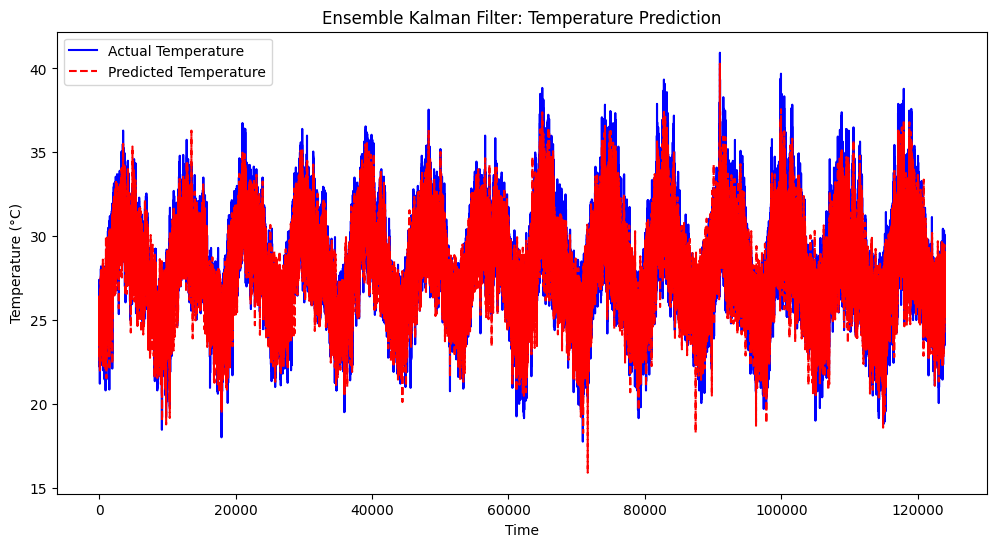

In [19]:
# Visualization: Actual vs. Predicted Temperature
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["temperature_2m"], label="Actual Temperature", color="blue")
plt.plot(predicted_df.index, predicted_df["temperature_2m"], label="Predicted Temperature", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Ensemble Kalman Filter: Temperature Prediction")
plt.legend()
plt.show()

____________

### EnKF Evaluation

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix

In [21]:

# Convert predicted states list to NumPy array
predicted_states = np.array(predicted_states)  # Shape: (num_samples, state_dim)

In [22]:
# Compute RMSE for each state variable
rmse = np.sqrt(mean_squared_error(observations, predicted_states, multioutput='raw_values'))

In [23]:
# Compute MAE for each state variable
mae = mean_absolute_error(observations, predicted_states, multioutput='raw_values')

In [24]:
# Compute R² Score
r2 = r2_score(observations, predicted_states, multioutput='raw_values')

In [25]:
# Compute Accuracy Score (for categorical predictions like rain/snow)
binary_threshold = 0.5  # Example threshold for classification
actual_classes = (observations[:, -1] > binary_threshold).astype(int)  # Example: last column as categorical
predicted_classes = (predicted_states[:, -1] > binary_threshold).astype(int)
accuracy = accuracy_score(actual_classes, predicted_classes)

In [26]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(actual_classes, predicted_classes)

In [27]:
# Display results
print("\n=== Numerical Evaluation Metrics ===")
for i, col in enumerate(df.columns[1:]):  # Skipping 'date' column
    print(f"{col}: RMSE={rmse[i]:.3f}, MAE={mae[i]:.3f}, R²={r2[i]:.3f}")

print(f"\nAccuracy Score (for categorical prediction): {accuracy:.3f}")


=== Numerical Evaluation Metrics ===
wind_speed_10m: RMSE=1.225, MAE=0.983, R²=0.813
cloud_cover: RMSE=2.346, MAE=1.846, R²=0.785
precipitation: RMSE=11.412, MAE=8.309, R²=0.819

Accuracy Score (for categorical prediction): 0.830


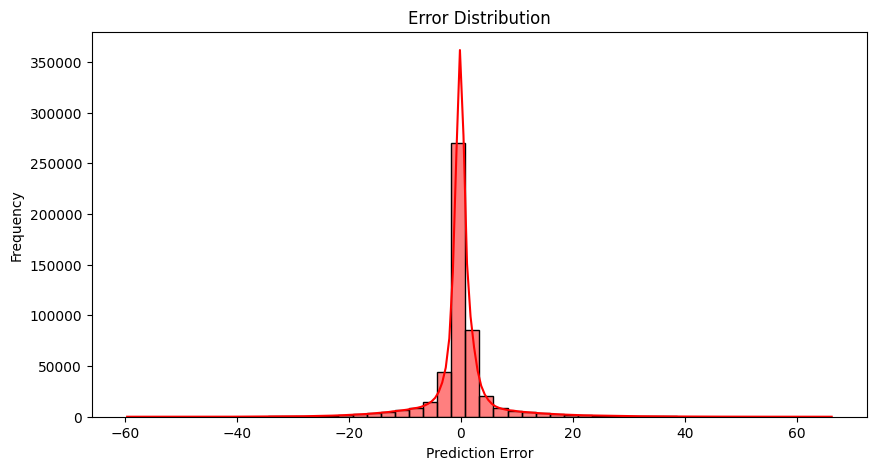

In [28]:
# Plot Error Distribution
plt.figure(figsize=(10, 5))
sns.histplot(observations.flatten() - predicted_states.flatten(), bins=50, kde=True, color='red')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.show()

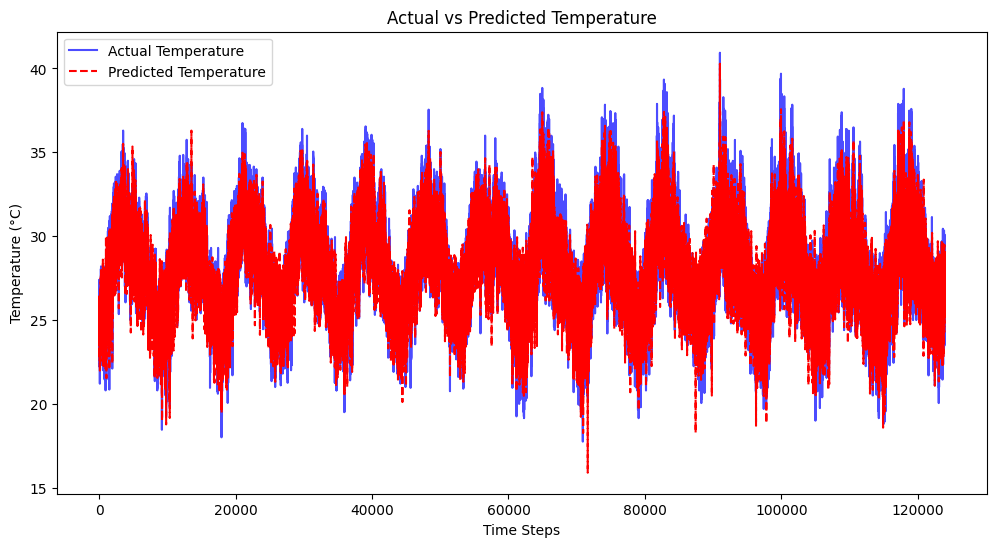

In [29]:

# Plot Actual vs Predicted for Temperature
plt.figure(figsize=(12, 6))
plt.plot(observations[:, 0], label="Actual Temperature", color='blue', alpha=0.7)
plt.plot(predicted_states[:, 0], label="Predicted Temperature", color='red', linestyle='dashed')
plt.xlabel("Time Steps")
plt.ylabel("Temperature (°C)")
plt.title("Actual vs Predicted Temperature")
plt.legend()
plt.show()

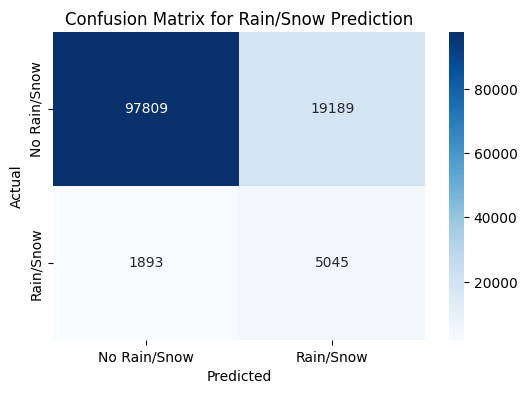

In [30]:
# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Rain/Snow", "Rain/Snow"], yticklabels=["No Rain/Snow", "Rain/Snow"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Rain/Snow Prediction")
plt.show()

___________

### Prediction

Generating 3-Day Forecast: 100%|██████████| 72/72 [00:00<00:00, 5726.34it/s]

Predicted State Shape: (72, 4)
Dataset Columns: Index(['temperature_2m', 'wind_speed_10m', 'cloud_cover', 'precipitation'], dtype='object')


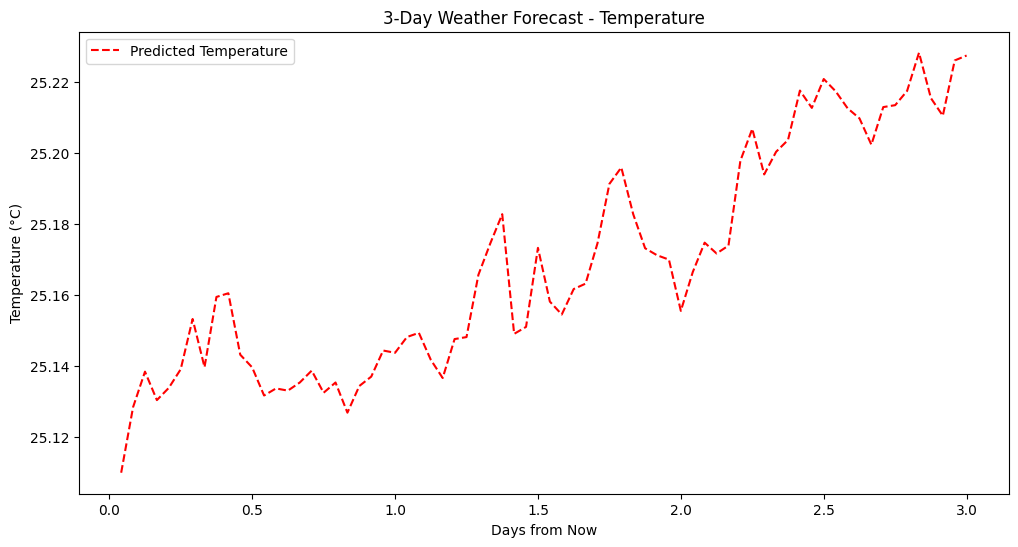

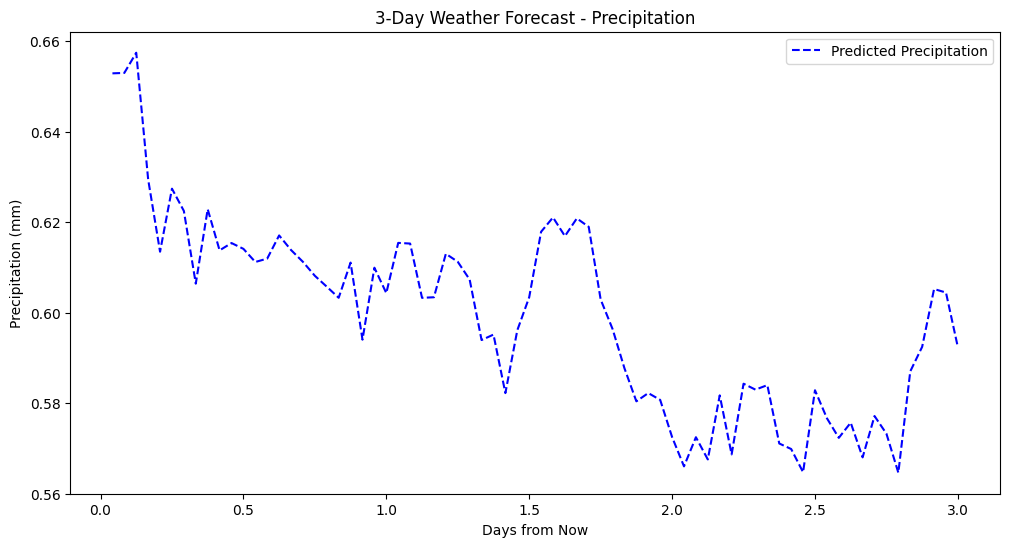


=== 3-Day Weather Forecast ===
      Day  Temperature (°C)  Precipitation (mm)
Day                                            
0    0.50             25.14                0.62
1    1.48             25.16                0.60
2    2.48             25.20                0.58
3    3.00             25.23                0.59


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# Define the number of forecast steps (3 days)
forecast_steps = 3 * 24  # Assuming hourly data, 72 time steps

# Ensure future predictions have the correct shape (match observations shape)
state_dim = observations.shape[1]  # Dynamically get number of columns
future_predictions = np.zeros((forecast_steps, state_dim))

# Start forecasting from the last known state
current_state = predicted_states[-1].copy()

# Run the EnKF model to predict the next 3 days
for i in tqdm(range(forecast_steps), desc="Generating 3-Day Forecast"):
    enkf.predict()
    future_predictions[i] = enkf.x.copy()

# Convert predictions into a readable format
days = np.arange(1, forecast_steps + 1) / 24  # Convert time steps to days

# **Check Available Columns**
print("Predicted State Shape:", future_predictions.shape)
print("Dataset Columns:", df.columns)

# **Get Correct Indices for Plotting**
temperature_idx = list(df.columns).index("temperature_2m")
precipitation_idx = list(df.columns).index("precipitation")

# **Plot the 3-day forecast for Temperature**
plt.figure(figsize=(12, 6))
plt.plot(days, future_predictions[:, temperature_idx], label="Predicted Temperature", color='red', linestyle='dashed')
plt.xlabel("Days from Now")
plt.ylabel("Temperature (°C)")
plt.title("3-Day Weather Forecast - Temperature")
plt.legend()
plt.show()

# **Plot the 3-day forecast for Precipitation**
plt.figure(figsize=(12, 6))
plt.plot(days, future_predictions[:, precipitation_idx], label="Predicted Precipitation", color='blue', linestyle='dashed')
plt.xlabel("Days from Now")
plt.ylabel("Precipitation (mm)")
plt.title("3-Day Weather Forecast - Precipitation")
plt.legend()
plt.show()

# **Print Forecasted Data for Key Weather Parameters**
forecasted_df = {
    "Day": np.arange(1, forecast_steps + 1) / 24,
    "Temperature (°C)": future_predictions[:, temperature_idx],
    "Precipitation (mm)": future_predictions[:, precipitation_idx]
}

forecast_df = pd.DataFrame(forecasted_df)
print("\n=== 3-Day Weather Forecast ===")
print(forecast_df.groupby(forecast_df["Day"].astype(int)).mean().round(2))

AttributeError: 'EnsembleKalmanFilter' object has no attribute 'ensembles'